# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [ ]:
library(tidyverse, warn.conflicts=FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

I want to use `theme_minimal()` by default:

In [ ]:
theme_set(theme_minimal())

And default image sizes aren’t great:

In [ ]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Data

Let’s start by getting our clusters and their statistics:

In [ ]:
clusters = read_parquet("book-links/cluster-stats.parquet", as_data_frame=FALSE)
glimpse(clusters)

Table
41,149,070 rows x 8 columns
$ cluster        <int32> 423896385, 454491654, 424930878, 449145631, 440372971, …
$ n_nodes       <uint32> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ n_isbns       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_loc_recs    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_editions <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_ol_works    <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ n_gr_books    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ n_gr_works    <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…

Describe the count columns for basic descriptive stats:

In [ ]:
clusters %>%
  select(-cluster) %>%
  collect() %>%
  summary()

    n_nodes             n_isbns           n_loc_recs       n_ol_editions     
 Min.   :     1.00   Min.   :    0.00   Min.   :   0.000   Min.   :    0.00  
 1st Qu.:     2.00   1st Qu.:    0.00   1st Qu.:   0.000   1st Qu.:    1.00  
 Median :     3.00   Median :    1.00   Median :   0.000   Median :    1.00  
 Mean   :     3.38   Mean   :    1.08   Mean   :   0.235   Mean   :    1.14  
 3rd Qu.:     4.00   3rd Qu.:    2.00   3rd Qu.:   0.000   3rd Qu.:    1.00  
 Max.   :106334.00   Max.   :51481.00   Max.   :1439.000   Max.   :44567.00  
   n_ol_works          n_gr_books         n_gr_works       
 Min.   :   0.0000   Min.   :   0.000   Min.   :  0.00000  
 1st Qu.:   1.0000   1st Qu.:   0.000   1st Qu.:  0.00000  
 Median :   1.0000   Median :   0.000   Median :  0.00000  
 Mean   :   0.8319   Mean   :   0.057   Mean   :  0.03699  
 3rd Qu.:   1.0000   3rd Qu.:   0.000   3rd Qu.:  0.00000  
 Max.   :2329.0000   Max.   :7378.000   Max.   :295.00000  

75% of clusters only contain 2 ISBNs (probably -10 and -13) and one
book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [ ]:
src_counts = clusters %>%
  summarize(across(-cluster, ~ sum(.x > 0))) %>%
  collect() %>%
  pivot_longer(everything(), names_to="source", values_to="count")
src_counts

# A tibble: 7 × 2
  source           count
  <chr>            <int>
1 n_nodes       41149070
2 n_isbns       24073256
3 n_loc_recs     9277944
4 n_ol_editions 34655323
5 n_ol_works    32823913
6 n_gr_books     1505224
7 n_gr_works     1504700

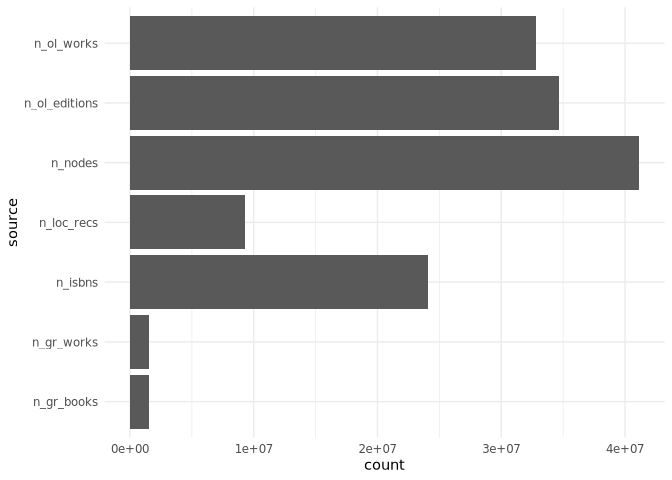

In [ ]:
ggplot(src_counts, aes(y=source, x=count)) +
  geom_bar(stat='identity')

## Distributions

Let’s look at the distributions of cluster sizes. Let’s first compute
histograms of the number of records per cluster for each cluster type.

In [ ]:
size_dists = collect(clusters) %>%
  gather(rec_type, nrecs, -cluster, factor_key=TRUE) %>%
  summarize(count=n(), .by=c("rec_type", "nrecs"))
head(size_dists)

# A tibble: 6 × 3
  rec_type nrecs    count
  <fct>    <int>    <int>
1 n_nodes      2 10611148
2 n_nodes      1  6960647
3 n_nodes      3  9248888
4 n_nodes      4  8154636
5 n_nodes      5  2148226
6 n_nodes      6  1107105

Warning in scale_x_log10(): log-10 transformation introduced infinite values.

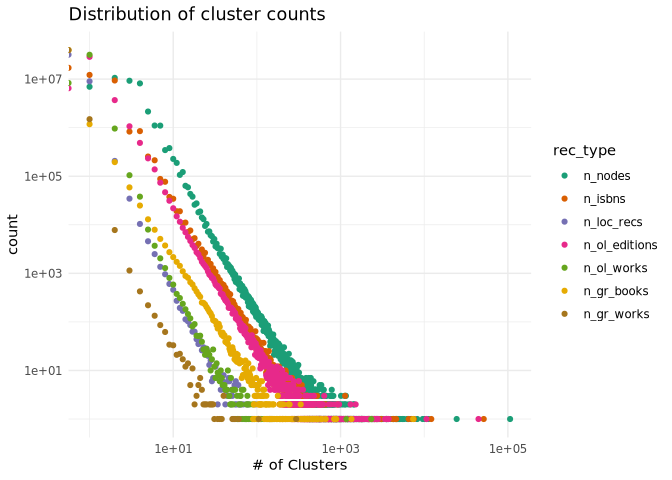

In [ ]:
ggplot(size_dists) +
  aes(x=nrecs, y=count, color=rec_type) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  scale_color_brewer(type="qual", palette="Dark2") +
  xlab("# of Records") +
  xlab("# of Clusters") +
  ggtitle("Distribution of cluster counts")

Looks mostly fine - we expect a lot of power laws - but the number of
clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

What’s going on with these clusters? Let’s take a peek at them.

In [ ]:
gr_big = clusters %>%
  filter(n_gr_works > 1) %>%
  arrange(desc(n_gr_works))
gr_big %>% glimpse()

Table (query)
10,080 rows x 8 columns
$ cluster        <int32> 100015971, 100017732, 104007890, 100027819, 108359025, …
$ n_nodes       <uint32> 106334, 9586, 520, 1602, 315, 337, 304, 513, 685, 610, …
$ n_isbns       <uint32> 51481, 4624, 194, 780, 141, 91, 120, 225, 245, 299, 248…
$ n_loc_recs    <uint32> 1439, 281, 6, 55, 1, 38, 3, 6, 2, 0, 0, 1, 111, 105, 0,…
$ n_ol_editions <uint32> 44567, 3721, 113, 462, 51, 64, 75, 113, 185, 170, 153, …
$ n_ol_works    <uint32> 1174, 342, 77, 78, 18, 58, 21, 38, 75, 45, 47, 25, 156,…
$ n_gr_books    <uint32> 7378, 513, 69, 172, 53, 46, 45, 91, 140, 60, 51, 46, 59…
$ n_gr_works    <uint32> 295, 105, 61, 55, 51, 40, 40, 40, 38, 36, 34, 31, 30, 3…
Call `print()` for query details

We have a lot of these clusters. What fraction of the GoodReads-affected
clusters is this?

In [ ]:
nrow(gr_big) / sum(!is.na(clusters$n_gr_books))

Scalar
0.0002449630088845264

Less than 1%. Not bad, but let’s look at these largest clusters.

In [ ]:
gr_big %>% head() %>% collect()

# A tibble: 6 × 8
    cluster n_nodes n_isbns n_loc_recs n_ol_editions n_ol_works n_gr_books
      <int>   <int>   <int>      <int>         <int>      <int>      <int>
1 100015971  106334   51481       1439         44567       1174       7378
2 100017732    9586    4624        281          3721        342        513
3 104007890     520     194          6           113         77         69
4 100027819    1602     780         55           462         78        172
5 108359025     315     141          1            51         18         53
6 100108007     337      91         38            64         58         46
# ℹ 1 more variable: n_gr_works <int>

## Large Cluster Debugging

We have some pretty big clusters:

In [ ]:
big = clusters %>% slice_max(n_nodes, n=5, with_ties=FALSE) %>%
  collect()
big

# A tibble: 5 × 8
    cluster n_nodes n_isbns n_loc_recs n_ol_editions n_ol_works n_gr_books
      <int>   <int>   <int>      <int>         <int>      <int>      <int>
1 100015971  106334   51481       1439         44567       1174       7378
2 100066513   24435   12152        190         10644         69       1352
3 114903691   11281    7520          0          3760          1          0
4 124349756   10678    7118          0          3559          1          0
5 101525098   10118    6518          7          3558         35          0
# ℹ 1 more variable: n_gr_works <int>

What is up with this? We should figure out what went wrong, if we can.
What are its ISBNs?

In [ ]:
isbns = read_parquet('book-links/all-isbns.parquet', as_data_frame=FALSE)
glimpse(isbns)

Table
44,471,261 rows x 7 columns
$ isbn_id     <int32> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…
$ isbn <large_string> "9783640435067", "9781107337145", "8478465820", "978031253…
$ LOC        <uint32> 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0…
$ OL         <uint32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ GR          <int64> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AZ14       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AZ18       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…

In [ ]:
links = read_parquet("book-links/isbn-clusters.parquet", as_data_frame=FALSE) %>%
  select(isbn_id, cluster)
glimpse(links)

Table (query)
44,471,261 rows x 2 columns
$ isbn_id <int32> 44471261, 44471260, 44471259, 44471258, 44471257, 44471256, 44…
$ cluster <int32> 944471261, 944471260, 944471259, 944471258, 944471257, 9444712…
Call `print()` for query details

Now let’s look up data for the largest cluster.

In [ ]:
big_id = big$cluster[1]
big_id

[1] 100015971

In [ ]:
bl = links %>% filter(cluster == big_id)
bl = semi_join(isbns, bl) %>% arrange(isbn)
bl %>% glimpse()

Table (query)
?? rows x 7 columns
$ isbn_id     <int32> 41577616, 42688032, 14338336, 24821157, 21065624, 26865403…
$ isbn <large_string> "0000744395", "000074445X", "0001004735", "0001004743", "0…
$ LOC        <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1…
$ OL         <uint32> 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3…
$ GR          <int64> 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1…
$ AZ14       <uint32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ AZ18       <uint32> 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Call `print()` for query details

What are the things with the highest record count?

In [ ]:
bl %>% collect() %>% rowwise() %>% mutate(
  btot = sum(c_across(!starts_with("isbn")))
) %>% slice_max(btot, n=20)

# A tibble: 51,481 × 8
# Rowwise: 
    isbn_id isbn         LOC    OL    GR  AZ14  AZ18  btot
      <int> <chr>      <int> <int> <int> <int> <int> <int>
 1 41577616 0000744395     0     0     1     0     0     1
 2 42688032 000074445X     0     0     1     0     0     1
 3 14338336 0001004735     0     1     0     0     0     1
 4 24821157 0001004743     0     1     0     0     0     1
 5 21065624 0001034375     0     1     0     0     0     1
 6 26865403 0001046403     0     1     0     0     0     1
 7 18792783 0001049283     0     1     0     0     0     1
 8 41009905 0001054783     0     1     0     0    75    76
 9 32680189 0001385208     0     1     0     0     0     1
10 32518057 0001660047     0     1     0     0     0     1
# ℹ 51,471 more rows